<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>


# <!-- TITLE --> [BHP1] - Regression with a Dense Network (DNN)
<!-- DESC --> A Simple regression with a Dense Neural Network (DNN) - BHPD dataset
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP), Laurent Risser (CNRS/IMT) -->

## Objectives :
 - Predicts **housing prices** from a set of house features. 
 - Understanding the **principle** and the **architecture** of a regression with a **dense neural network**  


The **[Boston Housing Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)** consists of price of houses in various places in Boston.  
Alongside with price, the dataset also provide theses informations : 

 - CRIM: This is the per capita crime rate by town
 - ZN: This is the proportion of residential land zoned for lots larger than 25,000 sq.ft
 - INDUS: This is the proportion of non-retail business acres per town
 - CHAS: This is the Charles River dummy variable (this is equal to 1 if tract bounds river; 0 otherwise)
 - NOX: This is the nitric oxides concentration (parts per 10 million)
 - RM: This is the average number of rooms per dwelling
 - AGE: This is the proportion of owner-occupied units built prior to 1940
 - DIS: This is the weighted distances to five Boston employment centers
 - RAD: This is the index of accessibility to radial highways
 - TAX: This is the full-value property-tax rate per 10,000 dollars
 - PTRATIO: This is the pupil-teacher ratio by town
 - B: This is calculated as 1000(Bk — 0.63)^2, where Bk is the proportion of people of African American descent by town
 - LSTAT: This is the percentage lower status of the population
 - MEDV: This is the median value of owner-occupied homes in 1000 dollars
## What we're going to do :

 - Retrieve data
 - Preparing the data
 - Build a model
 - Train the model
 - Evaluate the result


## Step 1 - Import and init

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


import numpy as np
import matplotlib.pyplot as plt
import sys,os

import pandas as pd

sys.path.append('..')
import fidle.pwk as ooo

from fidle_pwk_additional import convergence_history_MSELoss


## Step 2 - Retrieve data


Boston housing is a famous historic dataset, which can be get here: [Boston housing datasets](https://www.kaggle.com/puxama/bostoncsv)  

In [2]:
data = pd.read_csv('./BostonHousing.csv', header=0)

display(data.head(5).style.format("{0:.2f}").set_caption("Few lines of the dataset :"))
print('Missing Data : ',data.isna().sum().sum(), '  Shape is : ', data.shape)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1.00,296.00,15.30,396.90,4.98,24.00
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2.00,242.00,17.80,396.90,9.14,21.60
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2.00,242.00,17.80,392.83,4.03,34.70
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3.00,222.00,18.70,394.63,2.94,33.40
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3.00,222.00,18.70,396.90,5.33,36.20


Missing Data :  0   Shape is :  (506, 14)


## Step 3 - Preparing the data
### 3.1 - Split data
We will use 70% of the data for training and 30% for validation.  
The dataset is **shuffled** and shared between **learning** and **testing**.  
x will be input data and y the expected output

In [3]:
# ---- Suffle and Split => train, test
#
data_train = data.sample(frac=0.7, axis=0)
data_test  = data.drop(data_train.index)

# ---- Split => x,y (medv is price)
#
x_train = data_train.drop('medv',  axis=1)
y_train = data_train['medv']
x_test  = data_test.drop('medv',   axis=1)
y_test  = data_test['medv']

print('Original data shape was : ',data.shape)
print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)

Original data shape was :  (506, 14)
x_train :  (354, 13) y_train :  (354,)
x_test  :  (152, 13) y_test  :  (152,)


### 3.2 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will **subtract the mean** and **divide by the standard deviation**.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [4]:
display(x_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

display(x_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))
display(x_train.head(5).style.format("{0:.2f}").set_caption("Few lines of the dataset :"))

x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
count,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00
mean,3.97,11.41,11.11,0.07,0.55,6.31,68.85,3.81,10.05,414.90,18.48,356.21,12.61
std,8.99,23.03,6.83,0.25,0.11,0.71,28.32,2.14,8.88,170.70,2.12,92.28,7.30
min,0.01,0.00,0.46,0.00,0.39,4.14,6.00,1.13,1.00,187.00,13.00,0.32,1.73
25%,0.08,0.00,5.13,0.00,0.45,5.88,45.18,2.07,4.00,284.00,17.10,374.71,6.72
50%,0.29,0.00,9.69,0.00,0.53,6.23,77.75,3.21,5.00,348.00,19.10,390.95,11.27
75%,4.21,12.50,18.10,0.00,0.63,6.66,94.47,5.29,24.00,666.00,20.20,396.27,17.07
max,88.98,95.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,22.00,396.90,37.97


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
count,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00
mean,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.44,-0.50,-1.56,-0.27,-1.47,-3.04,-2.22,-1.26,-1.02,-1.34,-2.59,-3.86,-1.49
25%,-0.43,-0.50,-0.88,-0.27,-0.93,-0.59,-0.84,-0.82,-0.68,-0.77,-0.65,0.20,-0.81
50%,-0.41,-0.50,-0.21,-0.27,-0.19,-0.11,0.31,-0.28,-0.57,-0.39,0.29,0.38,-0.18
75%,0.03,0.05,1.02,-0.27,0.65,0.49,0.90,0.69,1.57,1.47,0.81,0.43,0.61
max,9.45,3.63,2.44,3.70,2.76,3.47,1.10,3.89,1.57,1.73,1.66,0.44,3.48


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
275,-0.43,1.24,-0.69,-0.27,-0.93,0.77,-0.92,0.21,-0.68,-0.94,-0.42,0.44,-1.32
51,-0.44,0.42,-0.80,-0.27,-1.00,-0.27,-0.21,1.41,-0.68,-1.01,-0.79,0.41,-0.44
54,-0.44,2.76,-1.04,-0.27,-1.26,-0.59,-0.75,1.64,-0.79,0.32,1.24,0.44,0.30
319,-0.39,-0.50,-0.18,-0.27,-0.09,-0.27,-0.35,0.09,-0.68,-0.65,-0.04,0.43,0.02
202,-0.44,3.09,-1.33,-0.27,-1.21,1.83,-1.88,1.15,-0.91,-0.39,-1.79,0.42,-1.30


## Step 4 - Build a model
About informations about : 
 - [Optimizer](https://pytorch.org/docs/stable/optim.html)
 - [Basic neural-network blocks](https://pytorch.org/docs/stable/nn.html)
 - [Loss](https://pytorch.org/docs/stable/nn.html#loss-functions)

In [5]:
class model_v1(nn.Module):
    """
    Basic fully connected neural-network for tabular data
    """
    def __init__(self,num_vars):
        super(model_v1, self).__init__()
        self.num_vars=num_vars
        self.hidden1 = nn.Linear(self.num_vars, 64)
        self.hidden2 = nn.Linear(64, 64)
        self.hidden3 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.view(-1,self.num_vars)   #flatten the observation before using fully-connected layers
        x = self.hidden1(x)
        x = F.relu(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = self.hidden3(x)
        return x



## Step 5 - Train the model

#### 5.1 - stochastic gradient descent strategy to fit the model

In [6]:
def fit(model,X_train,Y_train,X_test,Y_test, EPOCHS = 5, BATCH_SIZE = 32):
    
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3) #lr is the learning rate
    model.train()
    
    history=convergence_history_MSELoss()
    
    history.update(model,X_train,Y_train,X_test,Y_test)
    
    n=X_train.shape[0] #number of observations in the training data
    
    #stochastic gradient descent
    for epoch in range(EPOCHS):
        
        batch_start=0
        epoch_shuffler=np.arange(n) 
        np.random.shuffle(epoch_shuffler) #remark that 'utilsData.DataLoader' could be used instead
        
        while batch_start+BATCH_SIZE < n:
            #get mini-batch observation
            mini_batch_observations = epoch_shuffler[batch_start:batch_start+BATCH_SIZE]
            var_X_batch = Variable(X_train[mini_batch_observations,:]).float()
            var_Y_batch = Variable(Y_train[mini_batch_observations]).float()
            
            #gradient descent step
            optimizer.zero_grad()               #set the parameters gradients to 0
            Y_pred_batch = model(var_X_batch)   #predict y with the current NN parameters
            
            curr_loss = loss(Y_pred_batch.view(-1), var_Y_batch.view(-1))  #compute the current loss
            curr_loss.backward()                         #compute the loss gradient w.r.t. all NN parameters
            optimizer.step()                             #update the NN parameters
            
            #prepare the next mini-batch of the epoch
            batch_start+=BATCH_SIZE
            
        history.update(model,X_train,Y_train,X_test,Y_test)
    
    return history


##### 5.2 - get the model

In [7]:

   
model=model_v1( x_train[0,:].shape[0] )

print(model)



model_v1(
  (hidden1): Linear(in_features=13, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=64, bias=True)
  (hidden3): Linear(in_features=64, out_features=1, bias=True)
)


##### 5.3 - train the model

In [8]:


torch_x_train=torch.from_numpy(x_train)
torch_y_train=torch.from_numpy(y_train)
torch_x_test=torch.from_numpy(x_test)
torch_y_test=torch.from_numpy(y_test)

batch_size  = 10
epochs      = 100


history=fit(model,torch_x_train,torch_y_train,torch_x_test,torch_y_test,EPOCHS=epochs,BATCH_SIZE = batch_size)


## Step 6 - Evaluate
### 6.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  
A mae equal to 3 represents an average error in prediction of $3k.

In [9]:
var_x_test = Variable(torch_x_test).float()
var_y_test = Variable(torch_y_test).float()
y_pred = model(var_x_test)

nn_loss = nn.MSELoss()
nn_MAE_loss = nn.L1Loss()

print('x_test / loss      : {:5.4f}'.format(nn_loss(y_pred.view(-1), var_y_test.view(-1)).item()))
print('x_test / mae       : {:5.4f}'.format(nn_MAE_loss(y_pred.view(-1), var_y_test.view(-1)).item()))


x_test / loss      : 9.2881
x_test / mae       : 2.3158


### 6.2 - Training history
What was the best result during our training ?

In [11]:

df=pd.DataFrame(data=history.history)
df.describe()

,loss,mae,val_loss,val_mae
count,101.000000,101.000000,101.000000,101.000000
mean,23.476395,2.692269,23.864368,2.989625
std,76.294859,2.956140,74.627726,2.845627
min,3.821492,1.493004,8.697336,2.217072
25%,5.978652,1.768553,8.936612,2.270410
50%,8.439981,2.047496,9.364830,2.329784
75%,13.354569,2.480675,11.053273,2.494222
max,548.658447,21.719831,565.027466,22.106112


In [12]:
print("min( val_mae ) : {:.4f}".format( min(history.history["val_mae"]) ) )

min( val_mae ) : 2.2171


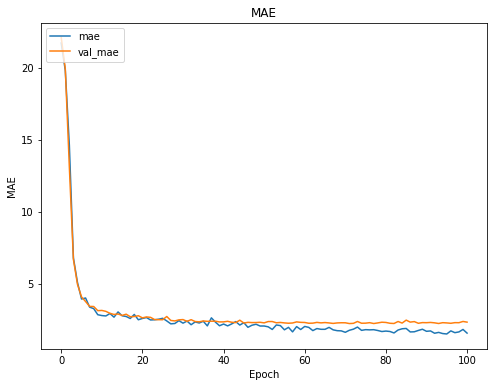

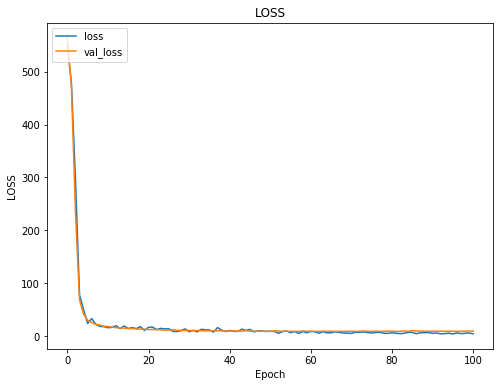

In [13]:
ooo.plot_history(history, plot={'MAE' :['mae', 'val_mae'],
                                'LOSS':['loss','val_loss']})

## Step 7 - Make a prediction
The data must be normalized with the parameters (mean, std) previously used.

In [14]:
my_data = [ 1.26425925, -0.48522739,  1.0436489 , -0.23112788,  1.37120745,
       -2.14308942,  1.13489104, -1.06802005,  1.71189006,  1.57042287,
        0.77859951,  0.14769795,  2.7585581 ]
real_price = 10.4

my_data=np.array(my_data).reshape(1,13)

In [18]:
torch_my_data=torch.from_numpy(my_data)
var_my_data = Variable(torch_my_data).float()

predictions = model( var_my_data )
print("Prediction : {:.2f} K$".format(predictions[0][0]))
print("Reality    : {:.2f} K$".format(real_price))

Prediction : 10.63 K$
Reality    : 10.40 K$


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>